# **DeepSVDD**

## **라이브러리 및 데이터 불러오기**

In [2]:
import numpy as np
import easydict
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import DataLoader
#from torchvision import datasets, transforms
#from PIL import Image
from sklearn.metrics import roc_auc_score, recall_score, precision_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train=pd.read_csv('../train.csv')
test=pd.read_csv('../test.csv')
train=train.drop('FRST_RCV_DT', axis=1)
test=test.drop('FRST_RCV_DT', axis=1)
target='FDS_CATH'

In [4]:
nunique = train.nunique()
types = train.dtypes

for col in train.columns:
    if types[col] == 'object' or nunique[col] <200:
        l_enc= LabelEncoder()
        train[col]= train[col].fillna("VV_likely")
        train[col]= l_enc.fit_transform(train[col].values)
        test[col]=l_enc.transform(test[col].values)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

## **범주형 변수를 임베딩**

In [21]:
embed=pd.read_csv('embedding_df.csv')
embed_train=embed.iloc[:len(train),:]
embed_train['FDS_CATH']=train['FDS_CATH']
embed_test=embed.iloc[len(train):,:].reset_index(drop=True)
embed_test['FDS_CATH']=test['FDS_CATH']

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
#scaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
embed_train.iloc[:,:-1]=scaler.fit_transform(embed_train.iloc[:,:-1])
embed_test.iloc[:,:-1]=scaler.transform(embed_test.iloc[:,:-1])

/home/users/adk8400153/.local/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [23]:
train_copy=embed_train.copy()
test_copy=embed_test.copy()

## **논문 코드 tabular 데이터에 맞게 변환**

In [25]:
class fraud_loader(data.Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        return x, y
    
    def __len__(self):
        return len(self.data)
    
def get_fraud_data(args, data_dir='.'):
    train = train_copy
    test = test_copy
    
    x_train = torch.tensor(train.iloc[:,:-1].to_numpy(), dtype=torch.float32)
    y_train = torch.tensor(train.iloc[:,-1].to_numpy(), dtype=torch.float32)
    
    x_train = x_train[np.where(y_train==0)]
    y_train = y_train[np.where(y_train==0)]
    
    data_train = fraud_loader(x_train, y_train)
    dataloader_train = DataLoader(data_train, batch_size=args.batch_size, shuffle=True, num_workers=1)
  
    
    ####Test####
    x_test = torch.tensor(test.iloc[:,:-1].to_numpy(), dtype=torch.float32)
    y_test = torch.tensor(test.iloc[:,-1].to_numpy(), dtype=torch.float32)
    
    data_test = fraud_loader(x_test, y_test)
    dataloader_test = DataLoader(data_test, batch_size=args.batch_size, shuffle=False, num_workers=1)
    
    return dataloader_train, dataloader_test

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args = easydict.EasyDict({
    'num_epochs':20,
    'num_epochs_ae':20, 
    'lr':1e-2,
    'lr_ae':1e-3,
    'weight_decay':5e-1,
    'weight_decay_ae':5e-2,
    'lr_milestones':[50],
    'batch_size': 1024,
    'pretrain': False, 
    'latent_dim': 4,
    'normal_class':0
})

In [27]:
dataloader_train, dataloader_test = get_fraud_data(args)

In [28]:
class DeepSVDD_network(nn.Module):
    def __init__(self, z_dim=4):
        super(DeepSVDD_network, self).__init__()
        self.z_dim = z_dim
        self.dropout = nn.Dropout(0.05)
        
        self.nn1 = nn.Linear(58, 128, bias=False)
        self.nn2 = nn.Linear(128, 32, bias=False)
        self.nn3 = nn.Linear(32, z_dim, bias=False)
        
        self.denn1 = nn.Linear(z_dim, 32, bias=False)
        self.denn2 = nn.Linear(32, 128, bias=False)
        self.denn3 = nn.Linear(128, 58, bias=False)
        
    def forward(self, x):
        x = self.dropout(x)
        x = self.nn1(x)
        x = F.leaky_relu(x)
        x = self.dropout(x)
        x = self.nn2(x)
        x = F.leaky_relu(x)
        return self.nn3(x)
    
class pretrain_autoencoder(nn.Module):
    def __init__(self, z_dim = 4):
        super(pretrain_autoencoder, self).__init__()
        self.z_dim = z_dim
        self.dropout = nn.Dropout(0.05)
        
        self.nn1 = nn.Linear(58, 128, bias=False)
        self.nn2 = nn.Linear(128, 32, bias=False)
        self.nn3 = nn.Linear(32, z_dim, bias=False)
        
        self.denn1 = nn.Linear(z_dim, 32, bias=False)
        self.denn2 = nn.Linear(32, 128, bias=False)
        self.denn3 = nn.Linear(128, 58, bias=False)        
    
    def encoder(self, x):
        x = self.dropout(x)
        x = self.nn1(x)
        x = F.leaky_relu(x)
        x = self.dropout(x)
        x = self.nn2(x)
        x = F.leaky_relu(x)
        return self.nn3(x)
    
    def decoder(self, x):
        x = self.dropout(x)
        x = self.denn1(x)
        x = F.leaky_relu(x)
        x = self.dropout(x)
        x = self.denn2(x)
        x = F.leaky_relu(x)
        x = self.denn3(x)
        return x
    
    #sigmoid해야 하나
    
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [29]:
class TrainerDeepSVDD:
    def __init__(self, args, data_loader, device):
        self.args = args
        self.train_loader = data_loader
        self.device = device
        
    def pretrain(self):
        """DeepSVDD모델에서 사용할 가중치를 학습시키는 AutoEncoder 학습단계"""
        ae = pretrain_autoencoder(self.args.latent_dim).to(self.device)
        ae.apply(weights_init_normal)
        optimizer = torch.optim.Adam(ae.parameters(), lr = self.args.lr_ae, weight_decay=self.args.weight_decay_ae)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = self.args.lr_milestones, gamma=0.1)
        
        ae.train()
        for epoch in range(self.args.num_epochs_ae):
            total_loss = 0
            for x, _ in self.train_loader:
                x = x.float().to(self.device)
                
                optimizer.zero_grad()
                x_hat = ae(x)
                reconst_loss = torch.mean(torch.sum((x_hat-x)**2, dim=tuple(range(1, x_hat.dim()))))
                reconst_loss.backward()
                optimizer.step()
                
                total_loss +=reconst_loss.item()
            scheduler.step()
            print('Pretrainin Autoencoder...Epoch:{}, Loss: {:.3f}'.format(
            epoch, total_loss/len(self.train_loader)))
        self.save_weights_for_DeepSVDD(ae, self.train_loader)
    
    def save_weights_for_DeepSVDD(self, model, dataloader):
        """학습된 AutoEncoder 가중치를 DeepSVDD 모델에 initialize 해주는 함수"""
        c = self.set_c(model, dataloader)
        net = DeepSVDD_network(self.args.latent_dim).to(self.device)
        state_dict = model.state_dict()
        net.load_state_dict(state_dict, strict=False)
        torch.save({'center': c.cpu().data.numpy().tolist(), 
                   'net_dict': net.state_dict()}, './weights/pretrained_parameters.pth')
        
    def set_c(self, model, dataloader, eps=0.1):
        model.eval()
        z_ = []
        with torch.no_grad():
            for x, _ in dataloader:
                x = x.float().to(self.device)
                z = model.encoder(x)
                z_.append(z.detach())
        z_ = torch.cat(z_)
        c = torch.mean(z_, dim=0)
        c[(abs(c) < eps) & (c < 0)] = -eps
        c[(abs(c) < eps) & (c > 0)] = eps
        return c

    
    def train(self):
        net = DeepSVDD_network().to(self.device)
        
        if self.args.pretrain == True:
            state_dict = torch.load('./weights/pretrained_parameters.pth')
            net.load_state_dict(state_dict['net_dict'])
            c = torch.Tensor(state_dict['center']).to(self.device)
        else:
            net.apply(weights_init_normal)
            c = torch.randn(self.args.latent_dim).to(self.device)
        
        optimizer = torch.optim.Adam(net.parameters(), lr=self.args.lr, weight_decay=self.args.weight_decay)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=self.args.lr_milestones, gamma =0.1)
        
        net.train()
        for epoch in range(self.args.num_epochs):
            total_loss = 0
            for x, _ in self.train_loader:
                x = x.float().to(self.device)
                
                optimizer.zero_grad()
                z = net(x)
                loss = torch.mean(torch.sum((z-c) **2, dim=1))
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
                
            scheduler.step()
            print('Training Deep SVDD...Epoch:{},Loss: {:.3f}'.format(
            epoch, total_loss/len(self.train_loader)))
        self.net = net
        self.c = c
        
        return self.net, self.c

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1 and classname != 'Conv' : 
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("Linear") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)

## **deep_svdd 모델링 실행**

In [30]:
deep_SVDD = TrainerDeepSVDD(args, dataloader_train, device)
#아키텍처를 잘짜면 성능이 좋아진다?
#정규화를 해볼까?
if args.pretrain:
    deep_SVDD.pretrain()

In [31]:
net, c =deep_SVDD.train()

Training Deep SVDD...Epoch:0,Loss: 0.388
Training Deep SVDD...Epoch:1,Loss: 0.040
Training Deep SVDD...Epoch:2,Loss: 0.041
Training Deep SVDD...Epoch:3,Loss: 0.041
Training Deep SVDD...Epoch:4,Loss: 0.043
Training Deep SVDD...Epoch:5,Loss: 0.042
Training Deep SVDD...Epoch:6,Loss: 0.042
Training Deep SVDD...Epoch:7,Loss: 0.045
Training Deep SVDD...Epoch:8,Loss: 0.044
Training Deep SVDD...Epoch:9,Loss: 0.041
Training Deep SVDD...Epoch:10,Loss: 0.042
Training Deep SVDD...Epoch:11,Loss: 0.048
Training Deep SVDD...Epoch:12,Loss: 0.043
Training Deep SVDD...Epoch:13,Loss: 0.041
Training Deep SVDD...Epoch:14,Loss: 0.054
Training Deep SVDD...Epoch:15,Loss: 0.039
Training Deep SVDD...Epoch:16,Loss: 0.039
Training Deep SVDD...Epoch:17,Loss: 0.041
Training Deep SVDD...Epoch:18,Loss: 0.047
Training Deep SVDD...Epoch:19,Loss: 0.042


In [32]:
def eval(net, c, dataloader, device):
    scores = []
    labels = []
    net.eval()
    print("Testing...")
    with torch.no_grad():
        for x, y in dataloader:
            x = x.float().to(device)
            z = net(x)
            score = torch.sum((z-c)**2, dim=1)
            
            scores.append(score.detach().cpu())
            labels.append(y.cpu())
    labels, scores = torch.cat(labels).numpy(), torch.cat(scores).numpy()
    print("ROC AUC score: {:.2f}".format(roc_auc_score(labels, scores)*100))
    return labels, scores

In [33]:
labels, scores = eval(net, c, dataloader_test, device)

Testing...
ROC AUC score: 57.05


In [34]:
np.quantile(scores, 0.97)

0.15663284063339233

## **결과 도출**

In [35]:
def get_result_svdd(labels, scores, quantile_num=0.97):
    
    prediction=np.where(scores>np.quantile(scores, quantile_num), 1,0)
    score = pd.DataFrame({'labels':labels, 'scores':scores, 'prediction':prediction})
    score.sort_values('scores', ascending=False, inplace=True)
    score=score.reset_index().drop('index', axis=1).copy()

    n_group=10
    group=['G01','G02','G03','G04','G05','G06','G07','G08','G09','G10']
    bins=round(len(score)/n_group)
    bins_1=len(score)-bins*(n_group-1)

    group_list=[]
    for i in range(n_group):
        if i <n_group-1:
            group_list.append(np.repeat(group[i], bins).tolist())
        else:
            group_list.append(np.repeat(group[i], bins_1).tolist())
    
    import itertools
    group_list=list(itertools.chain(*group_list))
    score['group']=pd.Series(group_list)

    function_list=['count','sum','mean']
    table=score.groupby(['group']).agg(function_list).reset_index()
    
    return score, table

In [36]:
score, table = get_result_svdd(labels, scores)

In [37]:
table

group labels                 scores                       prediction       \
         count   sum      mean  count         sum      mean      count  sum   
0   G01   1766  56.0  0.031710   1766  273.291473  0.154752       1766  530   
1   G02   1766  14.0  0.007928   1766  133.560303  0.075629       1766    0   
2   G03   1766  17.0  0.009626   1766   95.568169  0.054116       1766    0   
3   G04   1766  23.0  0.013024   1766   68.877243  0.039002       1766    0   
4   G05   1766  26.0  0.014723   1766   52.376408  0.029658       1766    0   
5   G06   1766  15.0  0.008494   1766   38.068901  0.021557       1766    0   
6   G07   1766  20.0  0.011325   1766   25.928223  0.014682       1766    0   
7   G08   1766  14.0  0.007928   1766   15.265416  0.008644       1766    0   
8   G09   1766  28.0  0.015855   1766    5.849361  0.003312       1766    0   
9   G10   1767  16.0  0.009055   1767    0.715600  0.000405       1767    0   

             
       mean  
0  0.300113  
1  0.000000  
2  0.000000  
3  0.000000  
4  0.000000  
5  0.000000  
6  0.000000  
7  0.000000  
8  0.000000  
9  0.000000

In [38]:
def make_plot(score, table, quantile_num=0.987):
    
    plt.figure(figsize=(10,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(table['group'], table['labels']['mean'], 'bo--')
    
    y_true=score['labels']
    y_score=score['scores']
    test_preds=np.where(y_score>np.quantile(y_score, quantile_num), 1, 0)
    print(f'precision score:{precision_score(y_true, test_preds)}')
    print(f'recall score: {recall_score(y_true, test_preds)}')
    print(f'auc acore:{roc_auc_score(y_true, y_score)}')
    cm=confusion_matrix(y_true, test_preds)
    
    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confision matrix")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")

precision score:0.10869565217391304
recall score: 0.1091703056768559
auc acore:0.5705395989106016


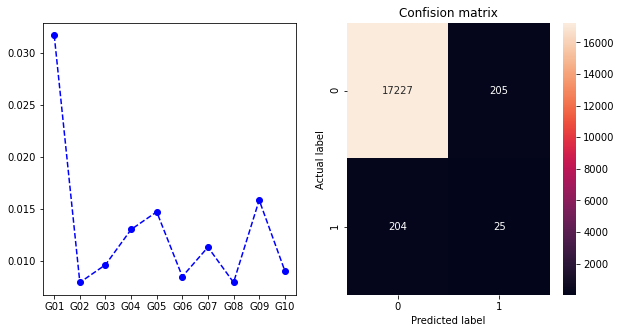

In [39]:
make_plot(score, table)